<a href="https://colab.research.google.com/github/nv-hiep/Autoencoders/blob/main/Recurrent_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Reshape, Input
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, Dropout, ActivityRegularization
from keras.layers import LSTM, RepeatVector, TimeDistributed, GaussianNoise

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    # plt.axis('off')

# Data

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train_full = X_train_full / 255.
X_test       = X_test / 255.

In [ ]:
print('X_train_full.shape: ', X_train_full.shape)
print('y_train_full.shape: ', y_train_full.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train_full.shape:  (60000, 28, 28)
y_train_full.shape:  (60000,)
X_test.shape:  (10000, 28, 28)
y_test.shape:  (10000,)


In [ ]:
train_size = 50_000

In [ ]:
X_train = X_train_full[:train_size]
X_valid = X_train_full[train_size:]

y_train = y_train_full[:train_size]
y_valid = y_train_full[train_size:]

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_valid.shape: ', X_valid.shape)
print('y_valid.shape: ', y_valid.shape)

X_train.shape:  (50000, 28, 28)
y_train.shape:  (50000,)
X_valid.shape:  (10000, 28, 28)
y_valid.shape:  (10000,)


In [ ]:
def show_reconstructions(model, images=X_test, n_images=5):
  '''
  First row: real images
  Second row: reconstructed images
  '''
  reconstructions = model.predict(images[:n_images])

  plt.figure(figsize=(n_images * 1.5, 3))
  # plt.title('Image reconstruction from Stacked Autoencoder')
  for img_id in range(n_images):
    plt.subplot(2, n_images, 1 + img_id)
    plot_image(images[img_id])
    plt.subplot(2, n_images, 1 + n_images + img_id)
    plot_image(reconstructions[img_id])
  plt.show()

# Recurrent Autoencoders

If you want to build an autoencoder for sequences, such as time series or text (e.g., for unsupervised learning or dimensionality reduction), then recurrent neural networks (RNN) may be better suited than dense networks. Building a recurrent autoencoder is straightforward: the encoder is typically a sequence-to-vector RNN which compresses the input sequence down to a single vector. The decoder is a vector-to-sequence RNN that does the reverse.

In [ ]:
# Encoder: a sequence-to-vector RNN which compresses the input sequence down to a single vector
recurrent_encoder = Sequential()
recurrent_encoder.add( LSTM(100, return_sequences=True, input_shape=[28,28]) )
recurrent_encoder.add( LSTM(30) )

# Decoder: vector-to-sequence RNN
recurrent_decoder = keras.models.Sequential()
recurrent_decoder.add( RepeatVector(28, input_shape=[30]) ) # to the shape: (None, 28, 30) 
recurrent_decoder.add( LSTM(100, return_sequences=True) )
recurrent_decoder.add( TimeDistributed(Dense(28, activation='sigmoid')) )

recurrent_autoencoder = Sequential([recurrent_encoder, recurrent_decoder])
recurrent_autoencoder.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(0.1), metrics=['binary_accuracy'])

In [ ]:
recurrent_encoder.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 28, 100)           51600     
_________________________________________________________________
lstm_6 (LSTM)                (None, 30)                15720     
Total params: 67,320
Trainable params: 67,320
Non-trainable params: 0
_________________________________________________________________


In [ ]:
recurrent_decoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_3 (ModuleWrap (None, 28, 30)            0         
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 28, 100)           52400     
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 28, 28)            2828      
Total params: 55,228
Trainable params: 55,228
Non-trainable params: 0
_________________________________________________________________


In [ ]:
recurrent_autoencoder.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_29 (Sequential)   (None, 30)                67320     
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 28, 28)            55228     
Total params: 122,548
Trainable params: 122,548
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = recurrent_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1563/1563 [==============================] - 22s 9ms/step - loss: 0.5623 - binary_accuracy: 0.4669 - val_loss: 0.4449 - val_binary_accuracy: 0.4900
Epoch 2/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.4243 - binary_accuracy: 0.4934 - val_loss: 0.3769 - val_binary_accuracy: 0.4924
Epoch 3/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.3703 - binary_accuracy: 0.4985 - val_loss: 0.3600 - val_binary_accuracy: 0.4952
Epoch 4/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.3558 - binary_accuracy: 0.4993 - val_loss: 0.3501 - val_binary_accuracy: 0.4970
Epoch 5/10
1563/1563 [==============================] - 13s 9ms/step - loss: 0.3483 - binary_accuracy: 0.4990 - val_loss: 0.3481 - val_binary_accuracy: 0.4923
Epoch 6/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.3395 - binary_accuracy: 0.5005 - val_loss: 0.3384 - val_binary_accuracy: 0.4999
Epoch 7/10
1563/1563 [========================

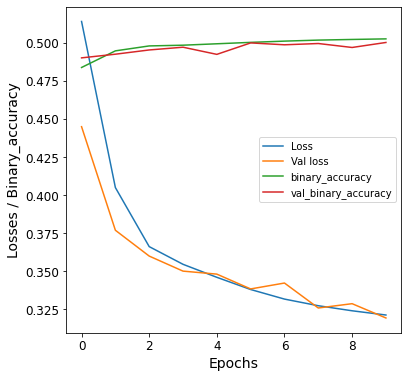

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Losses / Binary_accuracy')

plt.legend()
plt.show()

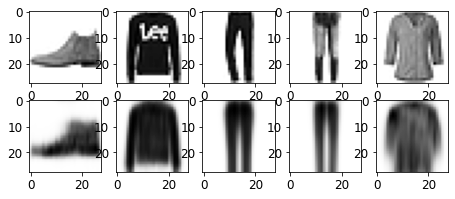

In [ ]:
# Plot the reconstructed images
show_reconstructions(recurrent_autoencoder, images=X_test)
plt.show()